In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import os

%matplotlib inline

In [ ]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example

    Args:
        X (ndarray): (m, n) Input values
        centroids (ndarray): (K, n) centroids

    Returns:
        idx (array_like): (m,) closest centroids

    """

    # Set K
    K = centroids.shape[0]

    idx = np.zeros(X.shape[0], dtype=int)

    m = X.shape[0]
    for i in range(m):
        idx[i] = -1
        distances = []
        for j in range(K):
            dist = np.dot(X[i]-centroids[j],X[i]-centroids[j])
            distances.append(dist)
            idx[i] = np.argmin(distances)

    return idx

In [ ]:
def upload_file(f_name):
  if not os.path.exists(f_name):
    url = f'https://raw.githubusercontent.com/orwertheim/PublicProjects/main/K%20means%20Image%20compression/{f_name}'
    response = requests.get(url)
    with open(f_name, 'wb') as f:
      f.write(response.content)


In [ ]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the
    data points assigned to each centroid.

    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each
                       example in X. Concretely, idx[i] contains the index of
                       the centroid closest to example i
        K (int):       number of centroids

    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """

    m, n = X.shape

    centroids = np.zeros((K, n))

    #add each example features to the centroid it belongs to
    np.add.at(centroids, idx, X)

    #count how many examples for each centroid
    counts = np.bincount(idx, minlength=K).reshape(K,1)

    #prevent zero divition
    counts[counts == 0]=1

    #calculate mean
    centroids = centroids/counts

    return centroids

In [ ]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """

    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))

    # Run K-Means
    for i in range(max_iters):

        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))

        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)

        # Optionally plot progress
        if plot_progress:
            #plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids

        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    plt.show()
    return centroids, idx

In [ ]:
def kMeans_init_centroids(X, K):
    """
    This function initializes K centroids that are to be
    used in K-Means on the dataset X

    Args:
        X (ndarray): Data points
        K (int):     number of centroids/clusters

    Returns:
        centroids (ndarray): Initialized centroids
    """

    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])

    # Take the first K examples as centroids
    centroids = X[randidx[:K]]

    return centroids

In [ ]:
# Load an image of a bird
upload_file('colorImage1.png')
original_img = plt.imread('colorImage1.png')

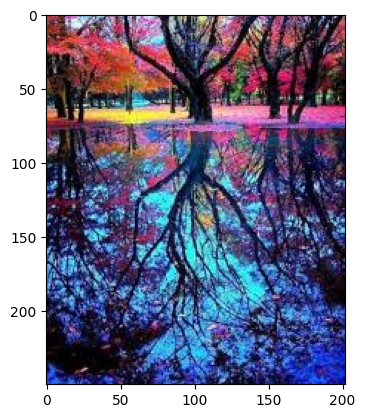

In [ ]:
# Visualizing the image
plt.imshow(original_img)

In [ ]:
print("Shape of original_img is:", original_img.shape)

Shape of original_img is: (250, 202, 3)


In [ ]:
# Divide by 255 so that all values are in the range 0 - 1 (not needed for PNG files)
# original_img = original_img / 255

# Reshape the image into an m x 3 matrix where m = number of pixels
# (in this case m = 128 x 128 = 16384)
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X_img that we will use K-Means on.

X_img = np.reshape(original_img, (original_img.shape[0] * original_img.shape[1], 3))

In [ ]:
# Run your K-Means algorithm on this data
# You should try different values of K and max_iters here
K = 16
max_iters = 10

# Using the function you have implemented above.
initial_centroids = kMeans_init_centroids(X_img, K)

# Run K-Means - this can take a couple of minutes depending on K and max_iters
centroids, idx = run_kMeans(X_img, initial_centroids, max_iters)

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


<Figure size 800x600 with 0 Axes>

In [ ]:
print("Shape of idx:", idx.shape)
print("Closest centroid for the first five elements:", idx[:5])

Shape of idx: (50500,)
Closest centroid for the first five elements: [13 13 10 13 10]


In [67]:
def plot_kMeans_RGB(X, centroids, idx, K):
    # Plot the colors and centroids in a 3D space
    fig = plt.figure(figsize=(22, 22))
    ax = fig.add_subplot(222, projection='3d')
    ax.scatter(*X.T*255, zdir='z', depthshade=False, s=.3, c=X)
    ax.scatter(*centroids.T*255, zdir='z', depthshade=False, s=500, c='red', marker='x', lw=3)
    ax.set_xlabel('R value - Redness')
    ax.set_ylabel('G value - Greenness')
    ax.set_zlabel('B value - Blueness')

    # Set the color of the Y-axis pane
    ax.yaxis.pane.fill = True
    ax.yaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_facecolor((0., 0., 0., .2))  # Set the color
    ax.set_title("Original colors and their color clusters' centroids")
    plt.show()

image:(50500, 3)


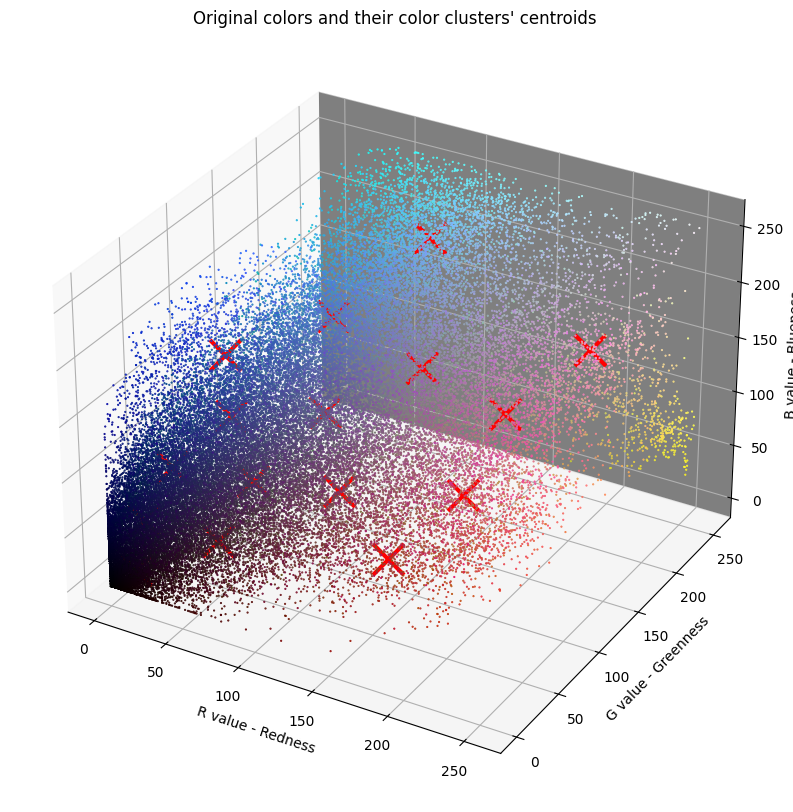

In [68]:
# Plot the colors of the image and mark the centroids
print(f'image:{X_img.shape}')
plot_kMeans_RGB(X_img, centroids, idx, K)

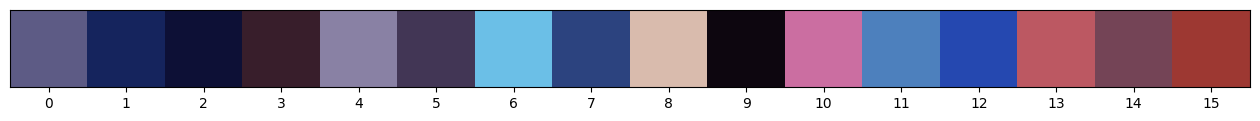

In [ ]:
# Visualize the 16 colors selected
def show_centroid_colors(centroids):
    palette = np.expand_dims(centroids, axis=0)
    num = np.arange(0,len(centroids))
    plt.figure(figsize=(16, 16))
    plt.xticks(num)
    plt.yticks([])
    plt.imshow(palette)

show_centroid_colors(centroids)

<a name="4.3"></a>
### 4.3 Compress the image


In [ ]:
# Find the closest centroid of each pixel
idx = find_closest_centroids(X_img, centroids)

# Replace each pixel with the color of the closest centroid
X_recovered = centroids[idx, :]

# Reshape image into proper dimensions
X_recovered = np.reshape(X_recovered, original_img.shape)

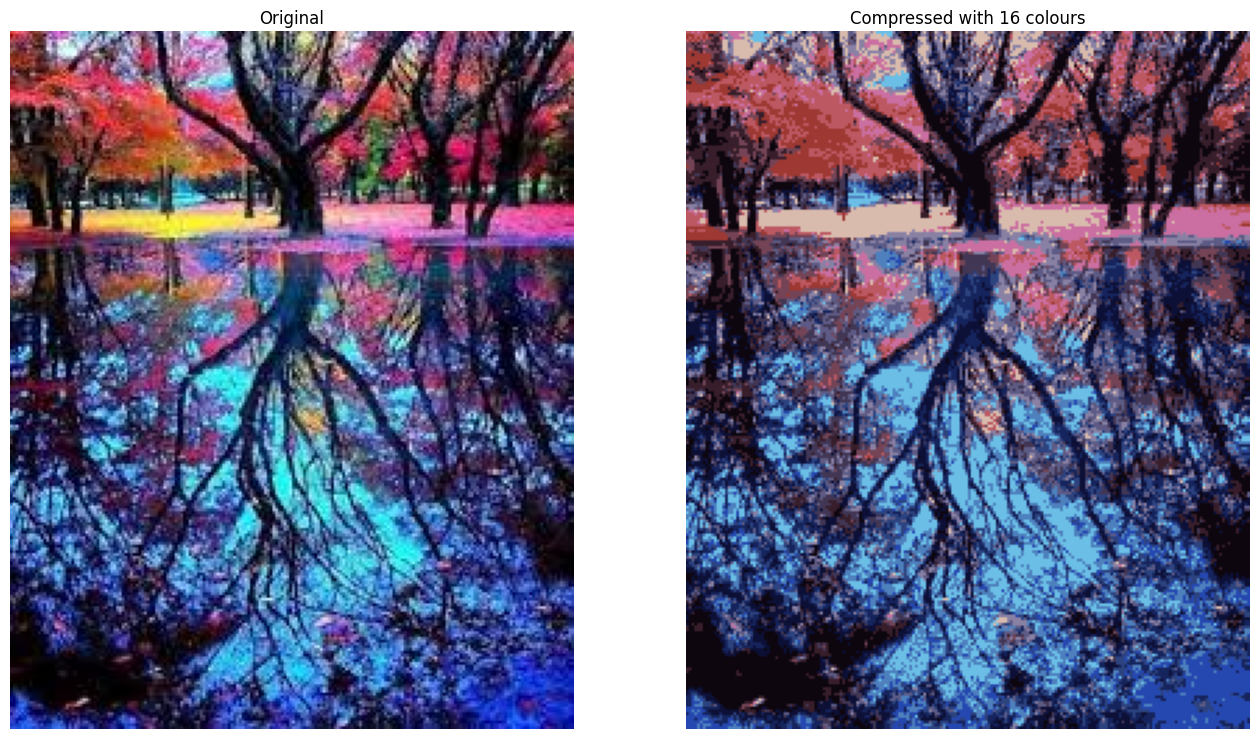

In [ ]:
# Display original image
fig, ax = plt.subplots(1,2, figsize=(16,16))
plt.axis('off')

ax[0].imshow(original_img)
ax[0].set_title('Original')
ax[0].set_axis_off()


# Display compressed image
ax[1].imshow(X_recovered)
ax[1].set_title('Compressed with %d colours'%K)
ax[1].set_axis_off()